In [2]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import torchvision
from PIL import Image as im
import torch.nn as nn
from torch.nn import Conv2d, Dropout
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
path_og = os.chdir("C:/Users/enriq/Desktop/comparativa_nn/FaceMask")
path_dataset = "C:/Users/enriq/Desktop/comparativa_nn/FaceMask/dataset/just_faces/"

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [15]:
#Estandarizar nombres de los archivos
path = 'dataset/just_faces/0/'
path2 = 'dataset/just_faces/1/'
try:
    i = 0
    for filename in os.listdir(path):
        
        os.rename(os.path.join(path,filename), os.path.join(path,str(i)+'.jpg'))
        i = i +1

    i2 = 0        
    for filename in os.listdir(path2):
        os.rename(os.path.join(path2,filename), os.path.join(path2,str(i2)+'.jpg'))
        i2 = i2 +1
except:
    print("Nombres cambiados")

Nombres cambiados


In [24]:
#Resize a 224x224
f = "C:/Users/enriq/Desktop/comparativa_nn/FaceMask/dataset/just_faces/0/"
for file in os.listdir(f):
    f_img = f+str(file)
    img = im.open(f_img)
    img = img.resize((224,224))
    img.save(f_img)
    
f1 = "C:/Users/enriq/Desktop/comparativa_nn/FaceMask/dataset/just_faces/1/"
for file1 in os.listdir(f1):
    f_img1 = f1+str(file1)
    img1 = im.open(f_img1)
    img1 = img1.resize((224,224))
    img1.save(f_img1)

1339
0
<class 'tuple'>


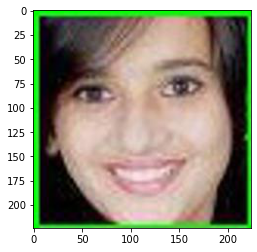

In [27]:
dataset = torchvision.datasets.ImageFolder(path_dataset)
print(len(dataset))
a =dataset[1]
print(a[1])
print(type(a))
plt.imshow(a[0])

In [28]:
transform = transforms.ToTensor()
lista=[]
df = pd.DataFrame()

for i in dataset:
    x=i[1]
    i=transform(i[0])
    lista.append([i,x])
#print(lista[800])

In [29]:
# Separamos en train y test
clases = ["Con", "Sin"]
train_data, test_data = torch.utils.data.random_split(lista, [686,653])

train_loader = DataLoader(train_data, batch_size=10, shuffle= True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle= True, pin_memory=True)
#print(train_data[0])

In [30]:
model = torchvision.models.resnet18(num_classes=len(clases)).cuda()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.cuda(), y_train.cuda()
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%20 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/690]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:  0  batch:   20 [   200/690]  loss: 0.03472010  accuracy:  90.500%
epoch:  0  batch:   40 [   400/690]  loss: 0.27132469  accuracy:  94.250%
epoch:  0  batch:   60 [   600/690]  loss: 0.02135969  accuracy:  95.500%
epoch:  1  batch:   20 [   200/690]  loss: 0.01557674  accuracy:  95.000%
epoch:  1  batch:   40 [   400/690]  loss: 0.01078197  accuracy:  95.500%
epoch:  1  batch:   60 [   600/690]  loss: 0.44983476  accuracy:  96.667%
epoch:  2  batch:   20 [   200/690]  loss: 0.03800892  accuracy:  96.000%
epoch:  2  batch:   40 [   400/690]  loss: 0.00389539  accuracy:  97.000%
epoch:  2  batch:   60 [   600/690]  loss: 0.00284392  accuracy:  97.667%
epoch:  3  batch:   20 [   200/690]  loss: 0.00411948  accuracy:  99.000%
epoch:  3  batch:   40 [   400/690]  loss: 0.00072003  accuracy:  99.250%
epoch:  3  batch:   60 [   600/690]  loss: 0.05373968  accuracy:  98.833%
epoch:  4  batch:   20 [   200/690]  loss: 0.13415501  accuracy:  95.000%
epoch:  4  batch:   40 [   400/690]  l

In [33]:
test_losses_item = []
print(test_losses)
for i in test_losses:
    print(i)
    test_losses_item.append(i.item())
test_losses_item

[tensor(0.0040, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.0167, device='cuda:0'), tensor(0.0319, device='cuda:0'), tensor(2.4996, device='cuda:0')]
tensor(0.0040, device='cuda:0')
tensor(0.0024, device='cuda:0')
tensor(0.0167, device='cuda:0')
tensor(0.0319, device='cuda:0')
tensor(2.4996, device='cuda:0')


[0.004024093970656395,
 0.0024205748923122883,
 0.016690703108906746,
 0.031866103410720825,
 2.499572277069092]

[1.0574856996536255, 0.04923771694302559, 0.18438027799129486, 0.010638758540153503, 0.008946940302848816]
[tensor(0.0040, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.0167, device='cuda:0'), tensor(0.0319, device='cuda:0'), tensor(2.4996, device='cuda:0')]


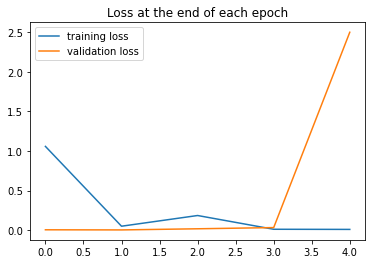

In [34]:
print(train_losses)
print(test_losses)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses_item, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [35]:
test_correct_item = []
print(test_correct)
for i in test_correct:
    print(i.item())
    test_correct_item.append(i.item())
test_correct_item

[tensor(642, device='cuda:0'), tensor(641, device='cuda:0'), tensor(646, device='cuda:0'), tensor(646, device='cuda:0'), tensor(636, device='cuda:0')]
642
641
646
646
636


[642, 641, 646, 646, 636]

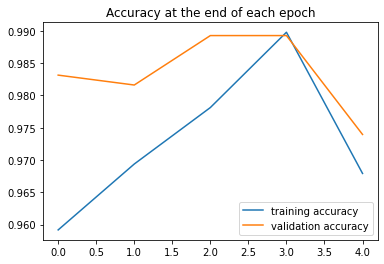

In [36]:
plt.plot([t/686 for t in train_correct], label='training accuracy')
plt.plot([t/653 for t in test_correct_item], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [37]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10, shuffle=False)

In [38]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.cuda(), y_test.cuda()
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 641/653 =  98.162%


In [39]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

0

In [40]:
# Set up an iterator to feed batched rows
r = 3   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

In [41]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
unloader = transforms.ToPILImage()  # reconvert into PIL image


In [42]:
def prediction_mascarilla(x):
    x = torch.tensor(x).cuda()
    #print(x.is_cuda)
    #print(test_data[x][0])
    image = test_data[x][0]
    #print(image.is_cuda)
    image = image.to(device)

    #print(image.is_cuda)
    #print(image.dtype)
    #print(image.type())

    imshow(image)
    model.eval()
    with torch.no_grad():
        new_pred = model(image.view(1,3,224,224)).argmax()
        if new_pred.item()==0:
            prediction = "Sin mascarilla"
        else:
            prediction = "Con mascarilla"
    print("Predicted value:",prediction)

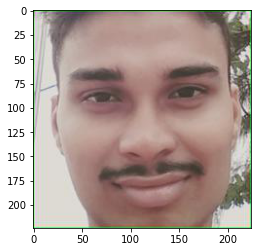

Predicted value: Sin mascarilla


In [56]:
prediction_mascarilla(652)